In [1]:
# EDA

from pymongo import MongoClient # import mongo client to connect
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, mean, stddev, min, max, desc
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
import urllib.parse
from sklearn.preprocessing import MinMaxScaler

In [2]:
username = "alextran21211"
password = urllib.parse.quote("database12345")
host = "cluster0.zsych.mongodb.net"
url = "mongodb+srv://{}:{}@{}/?retryWrites=true&w=majority".format(username,
password, host)
# connect to the database
client = MongoClient(url)

In [3]:
db = client['group_5_project']
collection = db["co2_emission"]

documents = collection.find()

data = []

for doc in documents:
    for country, country_data in doc.items():
        if country == "_id":
            continue  
        iso_code = country_data.get('iso_code')
        for entry in country_data.get('data', []):
            year = entry.get('year')
            population = entry.get('population')
            co2 = entry.get('cumulative_luc_co2')
           
            data.append({
                'Country': country,
                'ISO_Code': iso_code,
                'Year': year,
                'Population': population,
                'CO2': co2
            })


df = pd.DataFrame(data)


In [4]:
print(df.isnull().sum()) 

Country           0
ISO_Code       7867
Year              0
Population     8001
CO2           10393
dtype: int64


In [5]:
df['Population'] = df['Population'].fillna(df['Population'].mean()) 
df['CO2'] = df['CO2'].fillna(df['CO2'].mean())  
df['ISO_Code'] = df['ISO_Code'].dropna

In [6]:
df['CO2_per_capita'] = df['CO2'] / df['Population']

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df = df.drop(columns=['ISO_Code'])
print(df.head())

       Country  Year  Population        CO2  CO2_per_capita
0  Afghanistan  1850   3752993.0   2.979601    7.939267e-07
1  Afghanistan  1851   3767956.0   5.981443    1.587450e-06
2  Afghanistan  1852   3783940.0   9.002998    2.379266e-06
3  Afghanistan  1853   3800954.0  12.041333    3.167977e-06
4  Afghanistan  1854   3818038.0  15.094068    3.953357e-06


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for Seaborn plots
sns.set(style="whitegrid")


1. Trend in CO₂ Emissions Over Time

c:\Users\tranh\anaconda3\envs\adsc3910-project-group-5\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


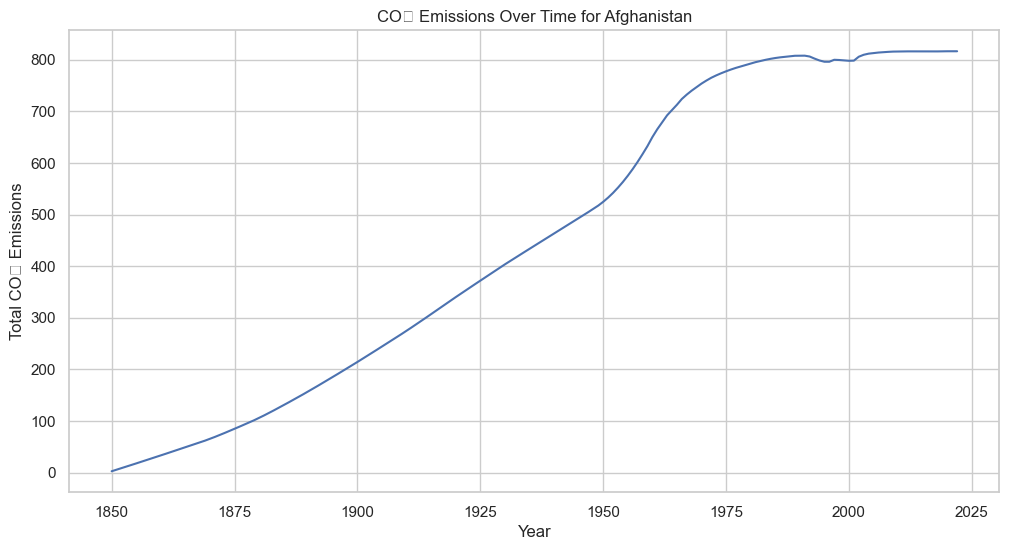

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df[df['Country'] == "Afghanistan"], x='Year', y='CO2', color="b")
plt.title("CO₂ Emissions Over Time for Afghanistan")
plt.xlabel("Year")
plt.ylabel("Total CO₂ Emissions")
plt.show()


2. CO₂ Emissions Per Capita Over Time

c:\Users\tranh\anaconda3\envs\adsc3910-project-group-5\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


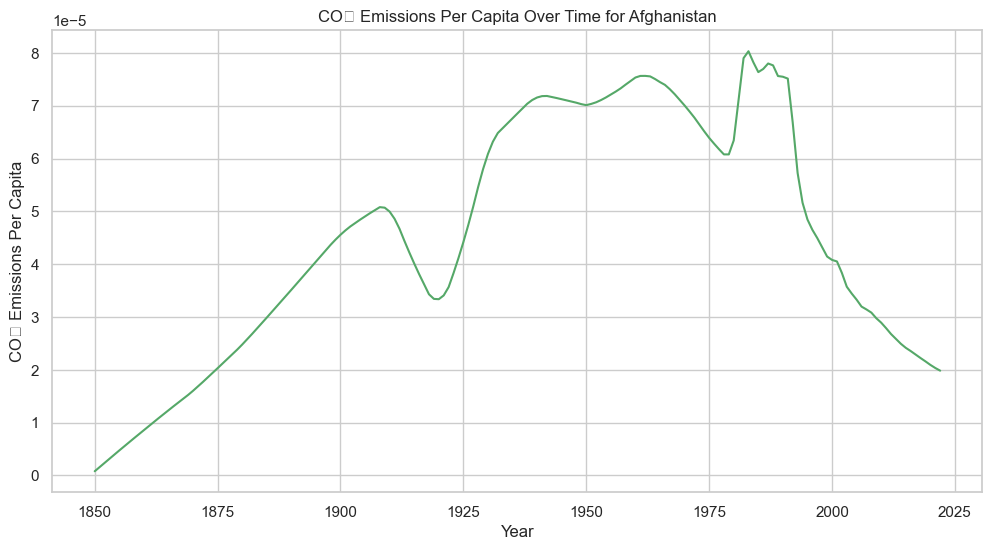

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df[df['Country'] == "Afghanistan"], x='Year', y='CO2_per_capita', color="g")
plt.title("CO₂ Emissions Per Capita Over Time for Afghanistan")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions Per Capita")
plt.show()
